In [1]:
from src.preprocessor.skyviewfactor_algorithm_qgisless import ProcessingSkyViewFactorAlgorithm as SVF
from src.processor.solweig_algorithm_qgisless_cupy import SOLWEIGAlgorithm as Solweig
from src.j_dataprep.DEMs import Buildings, DEMS, CHM
from src.j_dataprep.landcover import LandCover
from src.j_dataprep.user_input import Surface_input, Building3d_input
from src.j_dataprep.wall_preprocess import WallData
from src.j_output.user_output import TmrtOutput
from src.util.misc import saveraster
from osgeo import gdal

In [2]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import shape
import rasterio
import numpy as np

def show_raster_array(array, raster_type='generic', title='Raster', vmin=None, vmax=None):
    cmap_dict = {
        'height': 'viridis',
        'temperature': 'turbo',
        'generic': 'gray',
        'diverging': 'bwr'
    }

    cmap = cmap_dict.get(raster_type, 'gray')

    plt.figure(figsize=(7, 7))
    img = plt.imshow(array, cmap=cmap, vmin=vmin, vmax=vmax)
    plt.colorbar(img, label='Pixel Value')
    plt.title(title)
    plt.xlabel("Column")
    plt.ylabel("Row")
    plt.grid(False)
    plt.show()

def plot_geojson(geojson_list, crs="EPSG:28992", color='blue', edgecolor='black', labels=False):
    geoms = [shape(g['geometry']) for g in geojson_list]
    polygon_ids = [g.get('polygon_id', None) for g in geojson_list]

    gdf = gpd.GeoDataFrame({'polygon_id': polygon_ids, 'geometry': geoms}, crs=crs)

    ax = gdf.plot(color=color, edgecolor=edgecolor, figsize=(7, 7))

    if labels:
        for _, row in gdf.iterrows():
            centroid = row.geometry.centroid
            label = str(row['polygon_id']) if row['polygon_id'] is not None else ''
            ax.text(centroid.x, centroid.y, label, fontsize=8, ha='center', va='center', color='white')

    plt.title("Polygon Geometries")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.show()

def save_multilayer_dsm(dsm_array, crs, transform, filename):
    if isinstance(dsm_array, list):
        dsm_array = np.array(dsm_array)

    layers, height, width = dsm_array.shape

    with rasterio.open(
        filename,
        'w',
        driver='GTiff',
        height=height,
        width=width,
        count=layers,
        dtype=dsm_array.dtype,
        crs=crs,
        transform=transform,
    ) as dst:
        for i in range(layers):
            dst.write(dsm_array[i, :, :], i + 1)

## Start with retrieving context

#### Buildings

In [3]:
# All input that is officially needed: bbox for area
bbox= (123450,484200, 123700,484450)
buildings = Buildings(bbox)

loaded


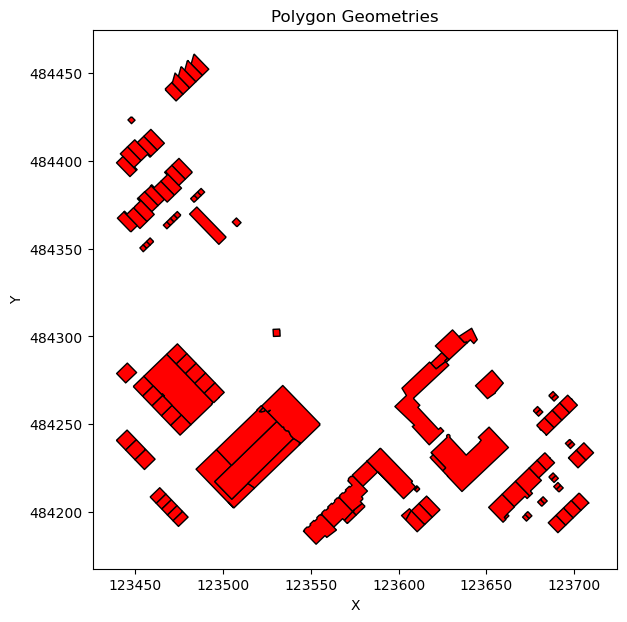

In [4]:
plot_geojson(buildings.building_geometries, color='red')

#### DEM

In [5]:
DSM = DEMS(bbox, buildings.building_geometries)

4
(500, 500)
4
(500, 500)
File written to 'output/final_dtm.tif'
File written to 'output/final_dsm.tif'


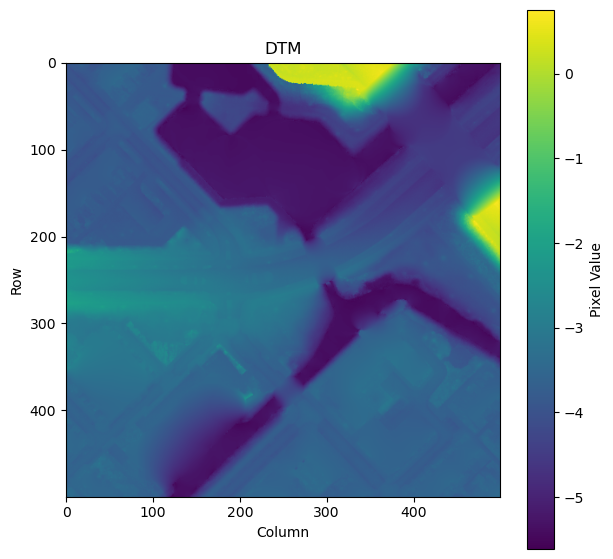

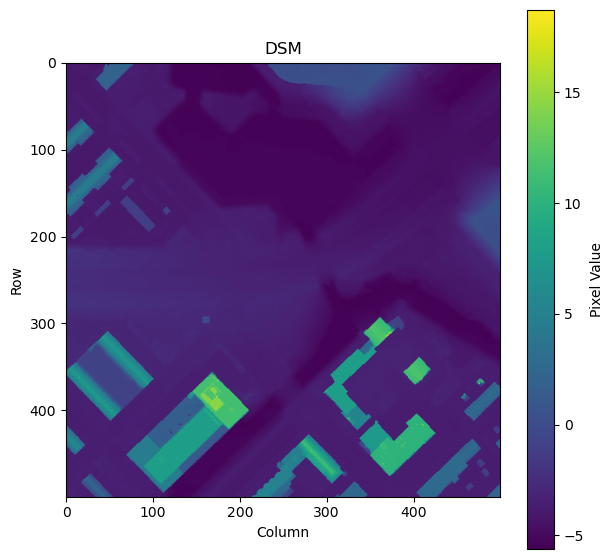

In [6]:
show_raster_array(DSM.dtm, raster_type='height', title='DTM')
show_raster_array(DSM.dsm, raster_type='height', title='DSM')

#### CHM

In [7]:
chm = CHM(bbox, DSM.dtm, DSM.dsm, trunk_height=25)

Tiles covering the area: ['25GN1_14']
Saved vegetation points to output\veg_points.las
(500, 500)
File written to 'output\CHM.TIF'


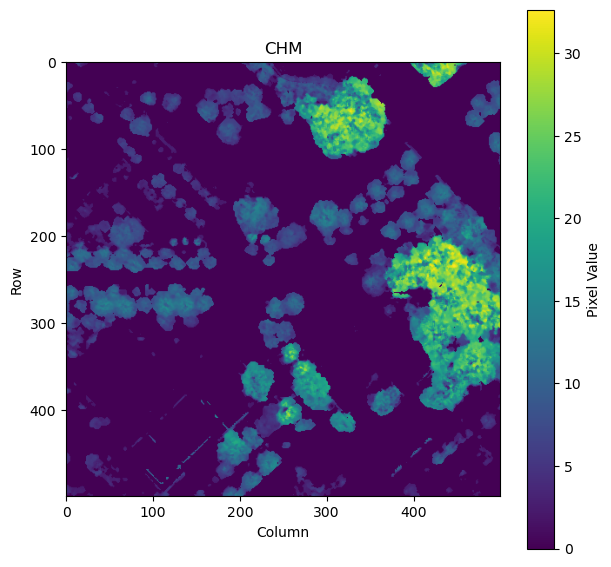

In [8]:
show_raster_array(chm.chm, raster_type='height', title='CHM')

#### Landcover

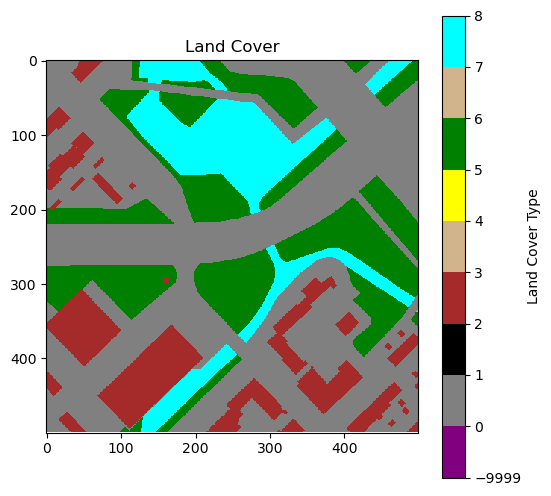

In [9]:
landcover = LandCover(bbox, main_roadtype=0, resolution=0.5, building_data=buildings.building_geometries, dataset_path="output/final_dtm.tif")

In [10]:
landcover.export_context('output/context.dxf')

Exported data to output/context.dxf


### The exported context and the made designs
<img src="figs/context_inrhino.png" alt="Context in rhino" width="50%"/>
<img src="figs/input.png" alt="Context in rhino" width="50%"/>


## Now update with design elements

#### First: remove a building

In [11]:
buildings.remove_buildings("NL.IMBAG.Pand.0363100012091340")
DSM.remove_buildings(buildings.removed_buildings, buildings.removed_user_buildings, buildings.building_geometries, buildings.user_buildings)

Parcel IDs being checked (to_remove): ['NL.IMBAG.Pand.0363100012098799', 'NL.IMBAG.Pand.0363100012072924', 'NL.IMBAG.Pand.0363100012090847', 'NL.IMBAG.Pand.0363100012134409', 'NL.IMBAG.Pand.0363100012126302', 'NL.IMBAG.Pand.0363100012126302', 'NL.IMBAG.Pand.0363100012188387', 'NL.IMBAG.Pand.0363100012188384', 'NL.IMBAG.Pand.0363100012110947', 'NL.IMBAG.Pand.0363100012102489', 'NL.IMBAG.Pand.0363100012188391', 'NL.IMBAG.Pand.0363100012100191', 'NL.IMBAG.Pand.0363100012188388', 'NL.IMBAG.Pand.0363100012071193', 'NL.IMBAG.Pand.0363100012071193', 'NL.IMBAG.Pand.0363100012089889', 'NL.IMBAG.Pand.0363100012120729', 'NL.IMBAG.Pand.0363100012150498', 'NL.IMBAG.Pand.0363100012101612', 'NL.IMBAG.Pand.0363100012101612', 'NL.IMBAG.Pand.0363100012188389', 'NL.IMBAG.Pand.0363100012123468', 'NL.IMBAG.Pand.0363100012128881', 'NL.IMBAG.Pand.0363100012147438', 'NL.IMBAG.Pand.0363100012075042', 'NL.IMBAG.Pand.0363100012142057', 'NL.IMBAG.Pand.0363100012097171', 'NL.IMBAG.Pand.0363100012138305', 'NL.IMBAG

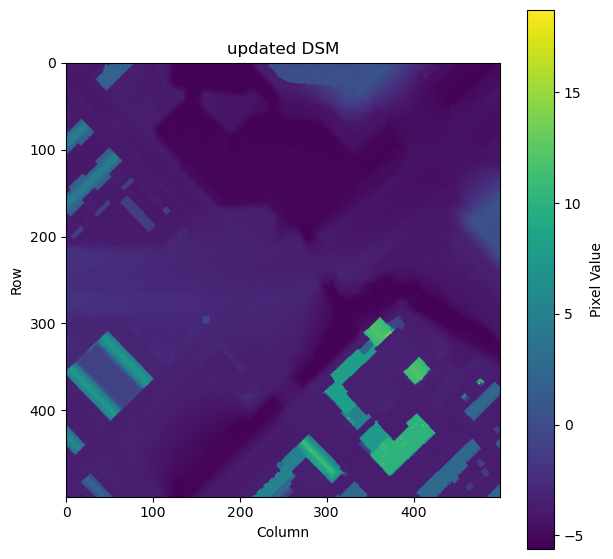

In [12]:
show_raster_array(DSM.dsm, raster_type='height', title='updated DSM')

#### Now insert the new design

In [13]:
dsms, highest_array, input_arrays = Building3d_input(DSM.dtm.shape[1], DSM.dtm.shape[0], DSM.resolution).rasterize_3dbuilding('output/new_building.obj', num_gaps=1)
buildings.insert_user_buildings(highest_array, DSM.transform, footprint_array=dsms[0])
# print(buildings.user_buildings_higher)
DSM.update_dsm(buildings.user_buildings, user_arrays=dsms, higher_buildings=buildings.user_buildings_higher)


In [14]:
dtm_dataset = gdal.Open('output/final_dtm.tif')

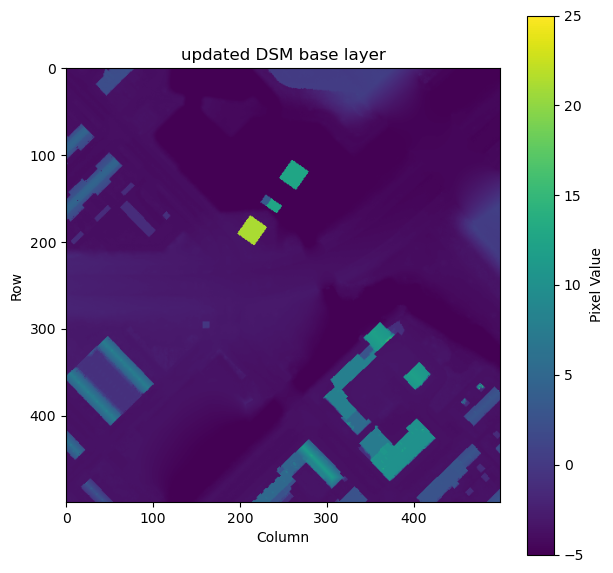

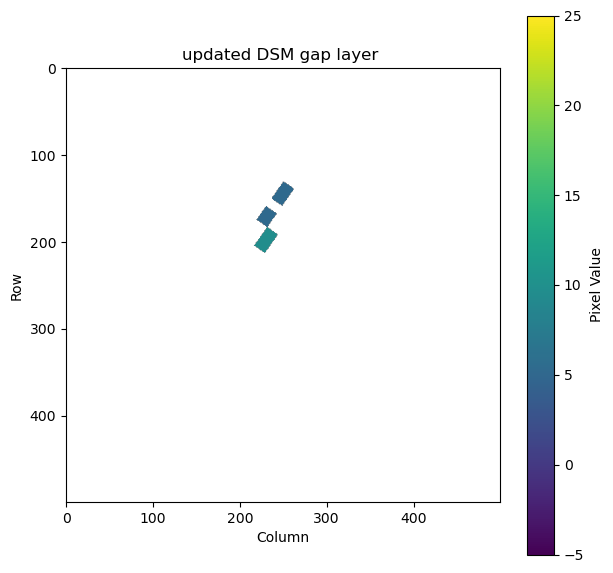

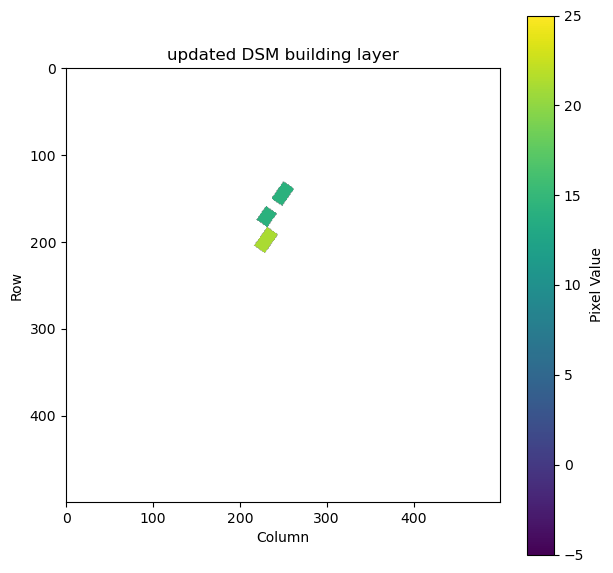

In [15]:
show_raster_array(DSM.dsm[0], raster_type='height', title='updated DSM base layer',vmin=-5, vmax=25)
show_raster_array(DSM.dsm[1], raster_type='height', title='updated DSM gap layer ',vmin=-5, vmax=25)
show_raster_array(DSM.dsm[2], raster_type='height', title='updated DSM building layer',vmin=-5, vmax=25)

#### Insert new water surface and building into landcover

In [16]:
landcover.update_build_landcover(buildings.user_buildings)
input_array, typeno = Surface_input(DSM.dtm.shape[1], DSM.dtm.shape[0], DSM.resolution).user_input_array('output/water.obj', type=['water', 'water'])
landcover.update_landcover(typeno, input_array)

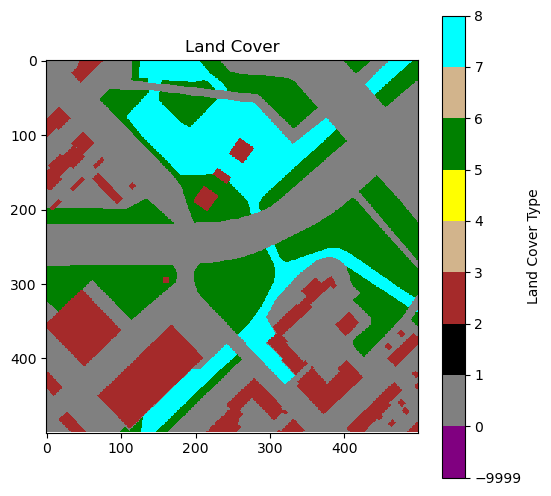

In [17]:
landcover.visualize_raster(landcover.array)

### Remove and insert a tree

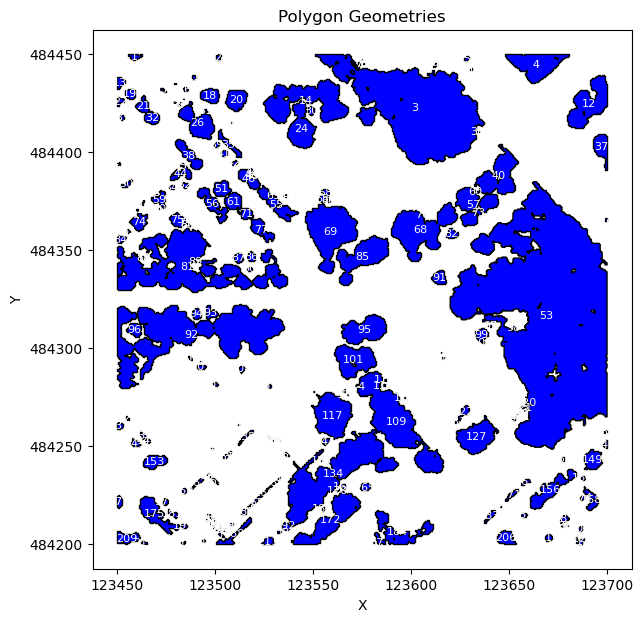

In [18]:
plot_geojson(chm.tree_polygons, labels=True)

In [19]:
chm.remove_trees(53)

File written to 'output/updated_chm.tif'


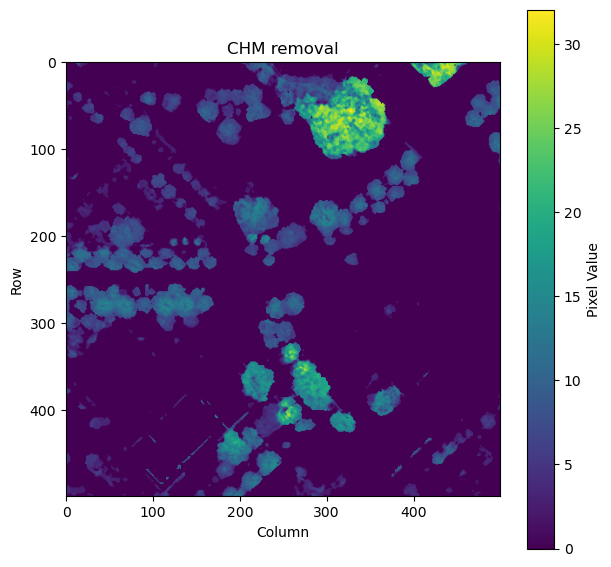

In [20]:
show_raster_array(chm.chm, raster_type='height', title='CHM removal')

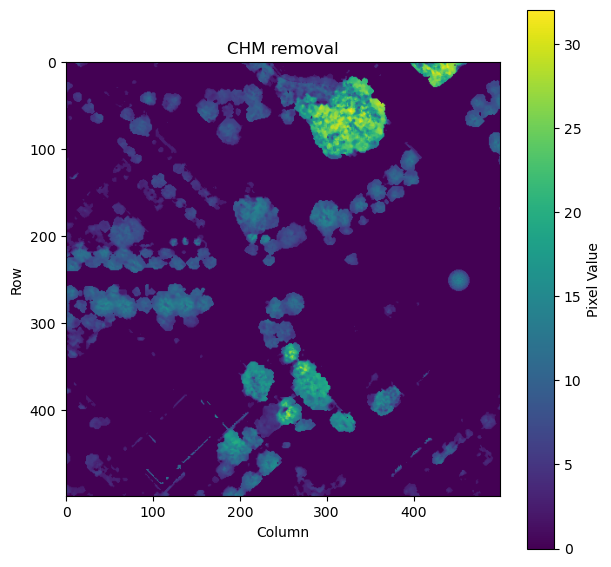

In [21]:
chm.insert_type_tree(age=50, position=(250, 450))
show_raster_array(chm.chm, raster_type='height', title='CHM removal')

In [22]:
# Save all rasters (currently SVF and SOLWEIG open tiffs and don't accept already existing ones)
mult_dsms_path = 'output/run_data/dsms.tif'
dtm_path = 'output/run_data/dsm.tif'
dsm_path = 'output/run_data/dsm.tif'
chm_path = 'output/run_data/chm.tif'
landcover_path = 'output/run_data/landcover.tif'
walla_path = 'output/run_data/wallaspect.tif'
wallh_path = 'output/run_data/wallheight.tif'

In [23]:
save_multilayer_dsm(DSM.dsm, DSM.crs, DSM.transform, mult_dsms_path)
saveraster(dtm_dataset, dsm_path , DSM.dsm[0])
saveraster(dtm_dataset,dtm_path, DSM.dtm)
saveraster(dtm_dataset, chm_path, chm.chm)
saveraster(dtm_dataset,landcover_path, landcover.array)

# create and save wall aspect and height
walls = WallData(DSM.dsm[0], 2)
saveraster(dtm_dataset,walla_path, walls.wall_aspect.get())
saveraster(dtm_dataset,wallh_path, walls.wall_height.get())


# CREATE SVF

In [25]:
# SVF(INPUT_DSM=dsm_path, INPUT_CDSM=chm_path, OUTPUT_DIR='output', OUTPUT_FILE='output/svf.tif', INPUT_DTM=dtm_path, INPUT_EXTRAHEIGHT=6, INPUT_MULT_DSMS = mult_dsms_path, INPUT_TDSM=None, USE_VEG=True, TRANS_VEG=15, TSDM_EXIST=False, INPUT_THEIGHT=25.0, ANISO=True).processAlgorithm_3d()

Initiating algorithm
Vegetation scheme activated
Calculating SVF using 153 iterations


C:\thesis\UMEP_thesis\src\util\shadowingfunctions.py:452: RuntimeWarning: divide by zero encountered in scalar divide
  dssin = np.abs(1.0 / sinazimuth)


0
1
1
2
3
3
4
5
5
6
7
7
8
9
9
10
11
11
12
13
13
14
15
15
16
16
17
18
18
19
20
20
21
22
22
23
24
24
25
26
26
27
28
28
29
30
30
31
32
32
33
33
34
35
35
36
37
37
38
39
39
40
41
41
42
43
43
44
45
45
46
47
47
48
49
49
50
50
51
52
52
53
54
54
55
56
56
57
58
58
59
60
60
61
62
62
63
64
64
65
66
66
67
67
68
69
69
70
71
71
72
73
73
74
75
75
76
77
77
78
79
79
80
81
81
82
83
83
84
84
85
86
86
87
88
88
89
90
90
91
92
92
93
94
94
95
96
96
97
98
98
99
100
Sky View Factor: SVF grid(s) successfully generated


{'output': 'output', 'output/svf.tif': 'output/svf.tif'}

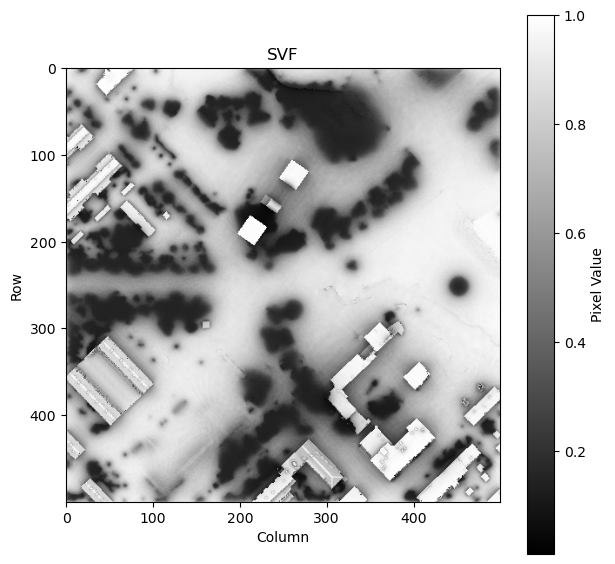

In [27]:
# svf_array = gdal.Open('output/svf.tif').ReadAsArray()
# show_raster_array(svf_array, raster_type='generic', title='SVF')

# RUN SOLFD

DSM raised with 11.6119995m.
Longitude derived from DSM: 4.924206395264258
Latitude derived from DSM: 52.34480783771364
Vegetation scheme activated
Land cover scheme activated
output/svfs/svfveg.tif
Sky View Factor rasters loaded
Meteorological data successfully loaded
Calculating sun positions for each time step
Sky divided into 153 patches
                                     Anisotropic sky for diffuse shortwave radiation (Perez et al., 1993) and longwave radiation (Martin & Berdahl, 1984)
Writing settings for this model run to specified output folder (Filename: RunInfoSOLWEIG_YYYY_DOY_HHMM.txt)
Executing main model
0
4
8
12
16
20
25
29
33
37
41
45
50
54
58
62
66
70
75
79
83
87
91
95
SOLWEIG: Model calculation finished.


{'output/SOLFD': 'output/SOLFD'}

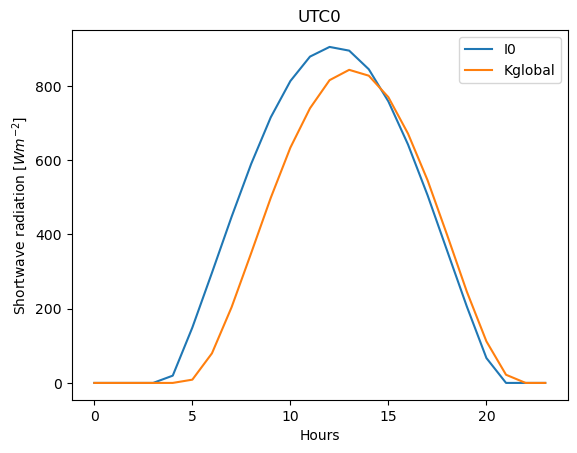

In [5]:
'''
met_data = 'src/j_dataprep/climate/extday_30plus_qgis.txt'

Solweig(INPUT_DSM=dsm_path, INPUT_SVF='output/svfs', INPUT_CDSM=chm_path,  INPUT_HEIGHT=wallh_path, INPUT_ASPECT=walla_path,
                 UTC=0, OUTPUT_DIR='output/SOLFD', INPUT_MET=met_data, INPUT_DTM=dtm_path, INPUT_EXTRAHEIGHT=6, INPUT_MULT_DSMS=mult_dsms_path, INPUT_LC=landcover_path,  INPUT_DEM=None, INPUT_ANISO='output/shadowmats.npz',
                 CONIFER_TREES=False, INPUT_THEIGHT=25, INPUT_TDSM=None, TRANS_VEG=15, LEAF_START=97, LEAF_END=300,
                 USE_LC_BUILD=True, SAVE_BUILD=False, ALBEDO_WALLS=0.2, ALBEDO_GROUND=0.15,
                 EMIS_WALLS=0.9, EMIS_GROUND=0.95, ABS_S=0.7, ABS_L=0.95, POSTURE=0,  ONLYGLOBAL=True,
                 OUTPUT_TMRT=True, OUTPUT_LUP=True, OUTPUT_KUP=True, OUTPUT_KDOWN=True, OUTPUT_LDOWN=True, OUTPUT_SH=True, OUTPUT_TREEPLANTER=False,
                 CYL=True).processAlgorithm_3d()
'''

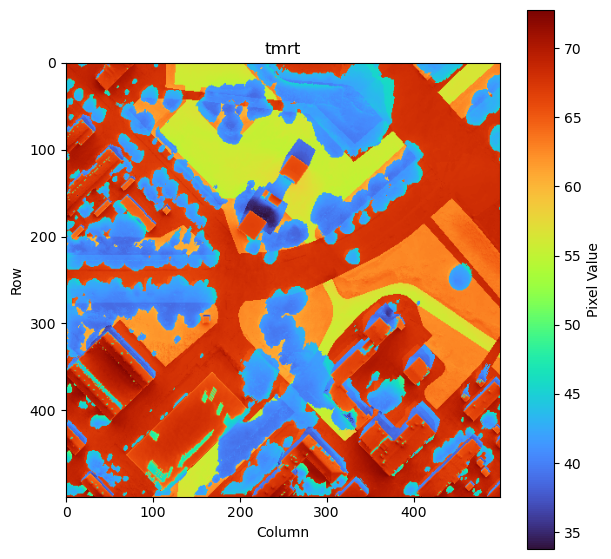

In [8]:
# tmrt_array = gdal.Open('output/SOLFD/Tmrt_2023_172_1300D.tif').ReadAsArray()
# show_raster_array(tmrt_array, raster_type='temperature', title='tmrt')

In [24]:
data = TmrtOutput('output/SOLFD', landcover.building_mask, landcover.water_mask)

### Calculate stats

In [27]:
data.calculate_stats_and_bins(data.tmrt_arrays_by_time['1200'])

{'mean': np.float32(55.53164),
 'median': np.float32(61.355114),
 'min': np.float32(33.610558),
 'max': np.float32(69.83232),
 'bins': [{'range': (np.float64(-inf), np.float64(15.0)),
   'area_m2': np.float64(0.0),
   'percentage': np.float64(0.0)},
  {'range': (np.float64(15.0), np.float64(20.0)),
   'area_m2': np.float64(0.0),
   'percentage': np.float64(0.0)},
  {'range': (np.float64(20.0), np.float64(25.0)),
   'area_m2': np.float64(0.0),
   'percentage': np.float64(0.0)},
  {'range': (np.float64(25.0), np.float64(30.0)),
   'area_m2': np.float64(0.0),
   'percentage': np.float64(0.0)},
  {'range': (np.float64(30.0), np.float64(35.0)),
   'area_m2': np.float64(110.25),
   'percentage': np.float64(0.2376500132027785)},
  {'range': (np.float64(35.0), np.float64(40.0)),
   'area_m2': np.float64(4791.25),
   'percentage': np.float64(10.327806129322562)},
  {'range': (np.float64(40.0), np.float64(45.0)),
   'area_m2': np.float64(11721.25),
   'percentage': np.float64(25.265806959211496)

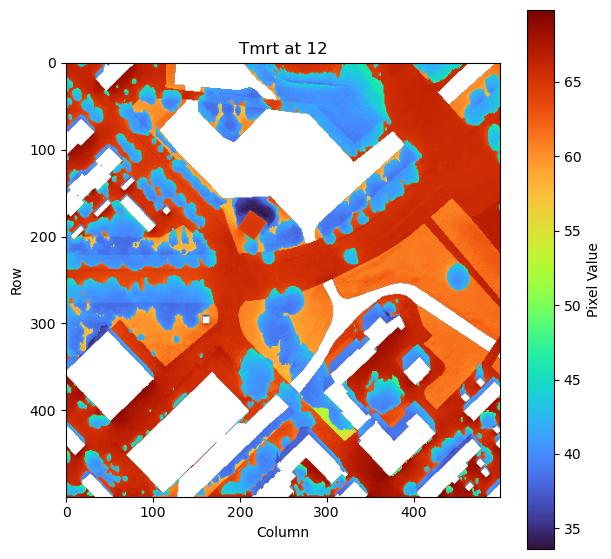

In [29]:
show_raster_array(data.tmrt_arrays_by_time['1200'], 'temperature', 'Tmrt at 12')

#### Pet arrays

In [30]:
data.calc_pet(Ta=28, RH=80, va=2.0)

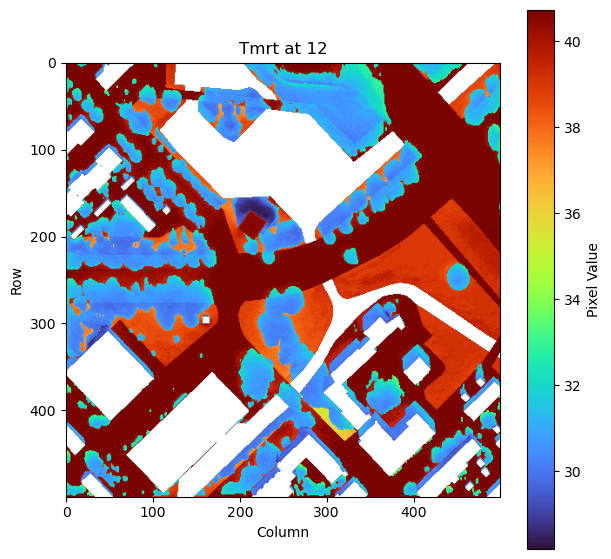

In [31]:
show_raster_array(data.pet_arrays_by_time['1200'], 'temperature', 'PET at 12')

In [32]:
classified_pet = data.classify_pet(data.pet_arrays_by_time['1200'])

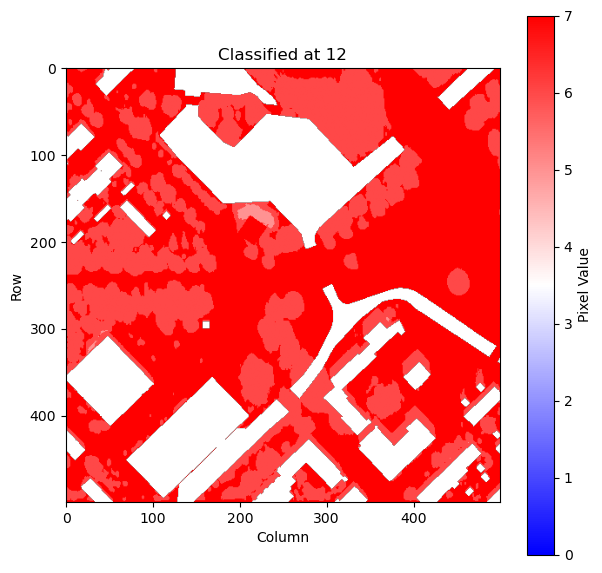

In [35]:
show_raster_array(classified_pet, 'diverging', 'Classified at 12', vmin=0, vmax=7)